In [14]:
import torch.distributions as dist
from Model import classification
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from bnn import bayesianize
import numpy as np
%matplotlib inline
import seaborn as sns
from functools import reduce
from clustergrammer2 import net
import pandas as pd

In [2]:
#Hyperparameter are based on table 4 of the paper
batch_size=64
train_dataset = datasets.FashionMNIST('FashionMNIST-data/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,), (1,),)]))
train_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size, shuffle=True)
test_dataset = datasets.FashionMNIST('FashionMNIST-data/', train=False, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,), (1,),)]))
test_loader = torch.utils.data.DataLoader(test_dataset,
        batch_size, shuffle=True)


In [3]:
#layer_size = number of hidden layers except the first and last layer
model_1 = classification(layer_size = 1, activation=False)
model_2 = classification(layer_size = 4, activation=False)
model_3 = classification(layer_size = 9, activation=False)
model_4 = classification(layer_size = 4, activation=True)
model_5 = classification(layer_size = 9, activation=True)

In [4]:
#You can find more information about bayesianize from https://github.com/microsoft/bayesianize
#Transforming the model to bayesian version of it
#To change the inference in the layers you should restart the kernel first
#For Mean field variational "ffg" should be used for inference,
#For full covariance variational "fcg" should be used for inference,
#choose your model between 5 different models
bayesianize.bayesianize_(model_4,inference=  "ffg")
print(model_4)
model = model_4

classification(
  (layers): ModuleList(
    (0): FFGLinear(in_features=784, out_features=16, bias=True, prior mean=0.00, prior sd=1.00)
    (1): FFGLinear(in_features=16, out_features=16, bias=True, prior mean=0.00, prior sd=1.00)
    (2): FFGLinear(in_features=16, out_features=16, bias=True, prior mean=0.00, prior sd=1.00)
    (3): FFGLinear(in_features=16, out_features=16, bias=True, prior mean=0.00, prior sd=1.00)
    (4): FFGLinear(in_features=16, out_features=16, bias=True, prior mean=0.00, prior sd=1.00)
    (5): FFGLinear(in_features=16, out_features=16, bias=True, prior mean=0.00, prior sd=1.00)
    (6): FFGLinear(in_features=16, out_features=16, bias=True, prior mean=0.00, prior sd=1.00)
    (7): FFGLinear(in_features=16, out_features=16, bias=True, prior mean=0.00, prior sd=1.00)
    (8): FFGLinear(in_features=16, out_features=16, bias=True, prior mean=0.00, prior sd=1.00)
  )
  (out): FFGLinear(in_features=16, out_features=10, bias=True, prior mean=0.00, prior sd=1.00)
)


In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0008)
#criterion = torch.nn.CrossEntropyLoss()

In [6]:
#variational test/train samples = 16
kl_factor = 0.1
epochs = 10
for epoch in range(epochs):
    top1_train_accuracy = 0
    for counter, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        for k in range(16):
            yhat = model(x_batch)
            nll = -dist.Categorical(logits=yhat).log_prob(y_batch).mean() / 16
            if k == 0:
                kl = torch.tensor(0.)
                for module in model.modules():
                    if hasattr(module, "parameter_loss"):
                        kl = kl + module.parameter_loss().sum()
                loss = nll + kl * kl_factor / len(train_dataset)
            else:
                loss = nll
            loss.backward()
        optimizer.step()
    model.eval()
    c=0
    with torch.no_grad():
        probs, targets = map(torch.cat, zip(*(
            (sum(model(x).softmax(-1) for _ in range(16)).div(16), y)
            for x, y in iter(test_loader)
        )))
    label_pred = np.argmax(probs, axis=1)
    correct = sum(label_pred == targets)
    accuracy = correct / len(targets)
    print(accuracy)
    #print(list(model.named_parameters()))

tensor(0.4688)
tensor(0.5660)
tensor(0.6508)
tensor(0.6823)
tensor(0.6879)
tensor(0.7075)
tensor(0.7182)
tensor(0.7244)
tensor(0.7274)
tensor(0.7284)


In [7]:
PATH = './model_4_net.pth'
torch.save(model,PATH)

In [79]:
PATH = './model_4_net.pth'
model = torch.load(PATH)

In [80]:
weights = dict()
for name, para in model.named_parameters():
    weights[name] = para

In [4]:
def sampling(mean,sd):
    shape = mean.shape
    mean = np.matrix.flatten(mean)
    sd = np.matrix.flatten(sd)
    results = []
    for i in range(len(mean)):
        results.append(np.random.normal(mean[i],abs(sd[i])))
    results = np.reshape(results,shape)
    return results

In [85]:
#Run thi part for model 1
weights_samples = []
for i in range(10000):
    out_layer = sampling(weights["out.weight_mean"].detach().numpy(),weights["out._weight_sd"].detach().numpy())
    first_layer = sampling(weights["layers.0.weight_mean"].detach().numpy(),weights["layers.0._weight_sd"].detach().numpy())
    product = reduce(np.matmul,(out_layer,
                      first_layer))
    weights_samples.append(np.matrix.flatten(product))


In [ ]:
#Run thi part for model 2
weights_samples = []
for i in range(10000):
    out_layer = sampling(weights["out.weight_mean"].detach().numpy(),weights["out._weight_sd"].detach().numpy())
    fourth_layer = sampling(weights["layers.3.weight_mean"].detach().numpy(),weights["layers.3._weight_sd"].detach().numpy())
    third_layer = sampling(weights["layers.2.weight_mean"].detach().numpy(),weights["layers.2._weight_sd"].detach().numpy())
    second_layer = sampling(weights["layers.1.weight_mean"].detach().numpy(),weights["layers.1._weight_sd"].detach().numpy())
    first_layer = sampling(weights["layers.0.weight_mean"].detach().numpy(),weights["layers.0._weight_sd"].detach().numpy())
    product = reduce(np.matmul,(out_layer,
                                fourth_layer,
                                third_layer,
                                second_layer,
                      first_layer))
    weights_samples.append(np.matrix.flatten(product))

In [75]:
#Run thi part for model 3
weights_samples = []
for i in range(10000):
    out_layer = sampling(weights["out.weight_mean"].detach().numpy(),weights["out._weight_sd"].detach().numpy())
    ninth_layer = sampling(weights["layers.8.weight_mean"].detach().numpy(),weights["layers.8._weight_sd"].detach().numpy())
    eighth_layer = sampling(weights["layers.7.weight_mean"].detach().numpy(),weights["layers.7._weight_sd"].detach().numpy())
    seventh_layer = sampling(weights["layers.6.weight_mean"].detach().numpy(),weights["layers.6._weight_sd"].detach().numpy())
    sixth_layer = sampling(weights["layers.5.weight_mean"].detach().numpy(),weights["layers.5._weight_sd"].detach().numpy())
    fifth_layer = sampling(weights["layers.4.weight_mean"].detach().numpy(),weights["layers.4._weight_sd"].detach().numpy())
    fourth_layer = sampling(weights["layers.3.weight_mean"].detach().numpy(),weights["layers.3._weight_sd"].detach().numpy())
    third_layer = sampling(weights["layers.2.weight_mean"].detach().numpy(),weights["layers.2._weight_sd"].detach().numpy())
    second_layer = sampling(weights["layers.1.weight_mean"].detach().numpy(),weights["layers.1._weight_sd"].detach().numpy())
    first_layer = sampling(weights["layers.0.weight_mean"].detach().numpy(),weights["layers.0._weight_sd"].detach().numpy())
    product = reduce(np.matmul,(out_layer,
                                ninth_layer,
                                eighth_layer,
                                seventh_layer,
                                sixth_layer,
                                fifth_layer,
                                fourth_layer,
                                third_layer,
                                second_layer,
                      first_layer))
    weights_samples.append(np.matrix.flatten(product))

In [86]:
covariance = np.cov(np.transpose(np.array(weights_samples)))

In [87]:
np.save('cov_4',covariance)

In [2]:
k1 = np.load("cov_1.npy")
k2 = np.load("cov_2.npy")
k3 = np.load("cov_3.npy")

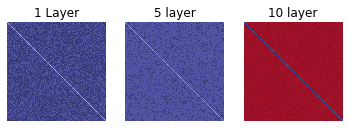

In [55]:
fig, axs = plt.subplots(1, 3)
#fig.suptitle('Covariance matrix heatmap')
axs[0].imshow(k1,cmap="tab20b", interpolation='nearest')
axs[0].set_title('1 Layer')
axs[0].set_axis_off()
axs[1].imshow(k2,cmap="tab20b", interpolation='nearest')
axs[1].set_title('5 layer')
axs[1].set_axis_off()
axs[2].imshow(k3,cmap="RdBu", interpolation='nearest')
axs[2].set_title('10 layer')
axs[2].set_axis_off()
plt.savefig('linear.png', bbox_inches='tight', pad_inches = 0)

In [15]:
# make row and col labels
rows = range(1,np.shape(k1)[0]+1)
cols = range(1,np.shape(k1)[1]+1)
rows = [str(i) for i in rows]
cols = [str(i) for i in cols]
df = pd.DataFrame(k1, columns=cols, index=rows)

KeyboardInterrupt: 

In [ ]:
net.load_df(df)
# make the visualization
net.widget()